# TP - Inpainting

In [1]:
# Include the src directory in Python import path
import os

os.chdir(os.getcwd())

# Imports
import numpy as np
from matplotlib import pyplot as plt
from src.preprocessing import patches, patch2image, genDCT
from src.ista import ista
from src.mod import mod

## I - Sparse representation in DCT dictionary

#### Image preprocessing

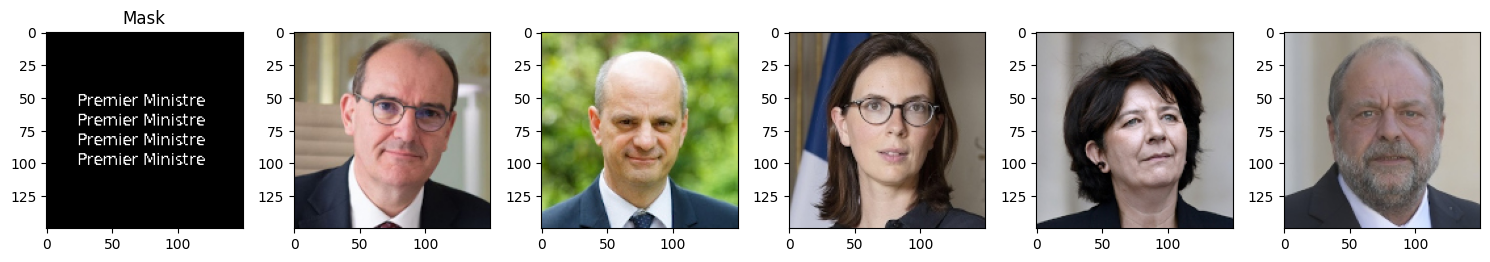

In [2]:
# Patch parameters
fact = np.array([1, 1, 1])      # over-completeness of DCT matrix (keep 1 or 2)
dims = np.array([12, 12, 3])    # patch dimensions
skip = 6                        # vertical translation between patches

# Reading the mask and the images
#   - Im0 is the mask (force binary entries only, zeros are corrupted pixels)
#   - Im1 is the Castex one that we be de-tagged
#   - Im2-Im5 are other images that will be used in the dictionary learning part
Im0 = plt.imread("img/mask.png")[:, :, 0:3] < 0.7   # increase up to 1 for harder problems
Im1 = plt.imread("img/castex.jpg")
Im2 = plt.imread("img/blanquer.jpg")
Im3 = plt.imread("img/de_montchalin.jpg")
Im4 = plt.imread("img/vidal.jpg")
Im5 = plt.imread("img/dupond_moretti.jpg")

# Extract patches from images
P0 = patches(Im0, dims, skip) < 0.7  # As in Im0, force binary entries only
P1 = patches(Im1, dims, skip)
P2 = patches(Im2, dims, skip)
P3 = patches(Im3, dims, skip)
P4 = patches(Im4, dims, skip)
P5 = patches(Im5, dims, skip)

# Displays
plt.figure(figsize=(15, 3))
plt.subplot(161)
plt.title("Mask")
plt.imshow(Im0[:, :, 0], cmap="gray")
plt.subplot(162)
plt.imshow(Im1)
plt.subplot(163)
plt.imshow(Im2)
plt.subplot(164)
plt.imshow(Im3)
plt.subplot(165)
plt.imshow(Im4)
plt.subplot(166)
plt.imshow(Im5)
plt.tight_layout()
plt.show()

#### Using ISTA to reconstruct from patch

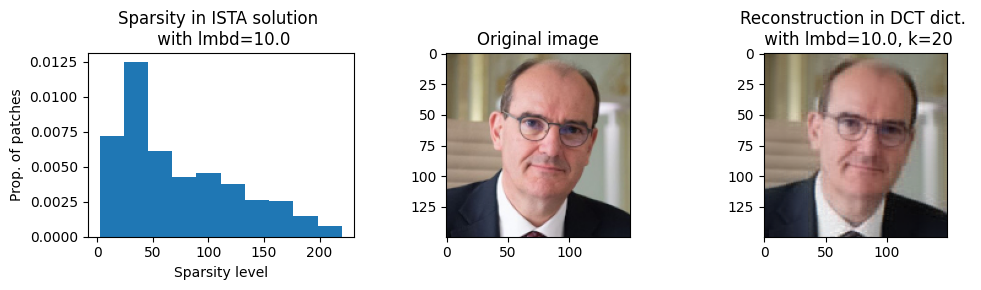

In [3]:
# DCT dictionary
D = genDCT(dims, fact)

# Problem hyperparameters
lmbd    = 1e1       # regularization strength
k       = 20        # target sparsity in the problem solution
tol     = 1e-3      # tolerance stopping criterion
maxit   = 20        # iteration stopping criterion

# Solve the problem
#   - X_ista is the output of ISTA
#   - X is X_ista but with only the k largest component kept per patch
X_ista, X, e = ista(P1, D, lmbd, k=20, tol=tol, maxit=maxit)

# Reconstruct the image from the sparse representation
P1_hat = D @ X
Im1_hat = patch2image(P1_hat, dims, skip, Im1.shape)

# Displays
plt.figure(figsize=(10, 3))
plt.subplot(131)
plt.title("Sparsity in ISTA solution \n with lmbd={}".format(lmbd))
plt.xlabel("Sparsity level")
plt.ylabel("Prop. of patches")
plt.hist(np.sum(np.ones(X_ista.shape), 0) - np.sum(X_ista == 0, 0), density=True)
plt.subplot(132)
plt.title("Original image")
plt.imshow(Im1)
plt.subplot(133)
plt.title("Reconstruction in DCT dict. \n with lmbd={}, k={}".format(lmbd, k))
plt.imshow(Im1_hat)
plt.tight_layout()
plt.show()

#### Corrupted Castex image

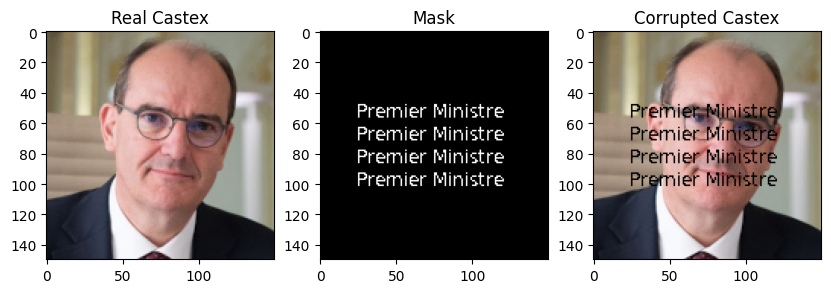

In [4]:
# Corrupt the Castex image (set black pixels at some locations)
Im1_tag = np.copy(Im1)
Im1_tag[Im0] = 0.0

# Extract patches from the corrupted image
P1_tag = patches(Im1_tag, dims, skip)

# Displays
plt.figure(figsize=(10, 10))
plt.subplot(131)
plt.title("Real Castex")
plt.imshow(Im1)
plt.subplot(132)
plt.title("Mask")
plt.imshow(Im0[:, :, 0], cmap="gray")
plt.subplot(133)
plt.title("Corrupted Castex")
plt.imshow(Im1_tag)
plt.show()

#### Using ISTA to fill corrupted pixels

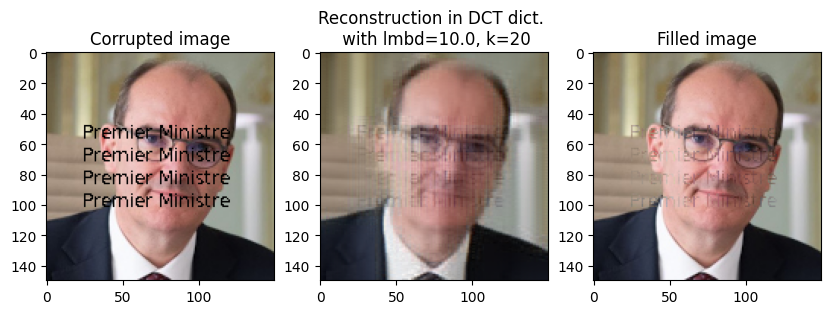

In [5]:
# DCT dictionary
D = genDCT(dims, fact)

# Problem hyperparameters
lmbd    = 1e1       # regularization strength
k       = 20        # target sparsity in the problem solution
tol     = 1e-3      # tolerance stopping criterion
maxit   = 20        # iteration stopping criterion

# Solve the problem
#   - Input the patches of the corrupted image
#   - Tell the function where missing pixels are with M=P0
X_ista, X, e = ista(P1_tag, D, lmbd, M=P0, k=20, tol=tol, maxit=maxit)

# Reconstructed image from patches
P1_hat = D @ X
Im1_hat = patch2image(P1_hat, dims, skip, Im1.shape)

# Corrupted patches are filled with the reconstructed ones
corrupted = np.invert(P0)
P1_fill = np.copy(P1_tag)
P1_fill[corrupted] = P1_hat[corrupted]
Im1_fill = patch2image(P1_fill, dims, skip, Im1.shape)

# Displays
plt.figure(figsize=(10, 8))
plt.subplot(131)
plt.title("Corrupted image")
plt.imshow(Im1_tag)
plt.subplot(132)
plt.title("Reconstruction in DCT dict. \n with lmbd={}, k={}".format(lmbd, k))
plt.imshow(Im1_hat)
plt.subplot(133)
plt.title("Filled image")
plt.imshow(Im1_fill)
plt.show()

## II - Dictionary Learning

#### Set training data and run the MOD algorithm

In [6]:
# Train data : all patches except the Castex ones
P_train = np.concatenate([P2, P3, P4, P5], 1)

# Problem hyperparameters
lmbd    = 1e1       # regularization strength
k       = 20        # target sparsity in the problem solution
tol     = 1e-3      # tolerance stopping criterion
maxit   = 20        # iteration stopping criterion

# Run the MOD algorithm that learns an appropriate dictionary from training 
# data. This can take 1-2 minutes. You can decrease maxit if necessary.
D_learn, X_learn, e_learn = mod(P_train, lmbd, dims, fact, k=k, maxit=maxit, tol=tol, verbose=True)

Initialisation...
Iter : 1, Err : 19.989182148211203
Iter : 2, Err : 17.91900760027812
Iter : 3, Err : 16.258184890172945
Iter : 4, Err : 15.345380729195252
Iter : 5, Err : 14.866981086829874
Iter : 6, Err : 14.461955391333138
Iter : 7, Err : 14.105752741275088
Iter : 8, Err : 13.961757903394098
Iter : 9, Err : 13.808259977631893
Iter : 10, Err : 13.682478344994207
Iter : 11, Err : 13.480994379991738
Iter : 12, Err : 13.462629370579522
Iter : 13, Err : 13.218304407171106
Iter : 14, Err : 13.106583895433733
Iter : 15, Err : 13.003090533805764
Iter : 16, Err : 12.871102211167075
Iter : 17, Err : 12.806614352290932
Iter : 18, Err : 12.795999351648915
Tol reached


#### Represent some learned atoms

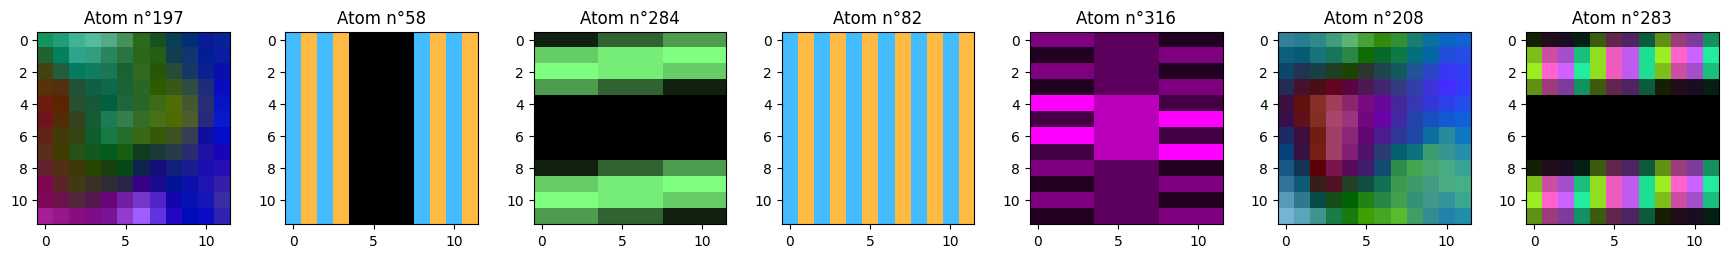

In [7]:
# Plot some atoms (chosen randomly) in the learned dictionary
plt.figure(figsize=(20, 10))
for i in range(1, 8):
    plt.subplot(1, 8, i)
    index = np.random.randint(0, D_learn.shape[0])
    temp = np.reshape(D_learn[:, index], dims)
    temp = np.uint8(np.abs(temp) / np.max(np.abs(temp)) * 255)
    plt.title("Atom n°{}".format(index))
    plt.imshow(temp)
plt.tight_layout()
plt.show()

#### See how learning images were reconstructed

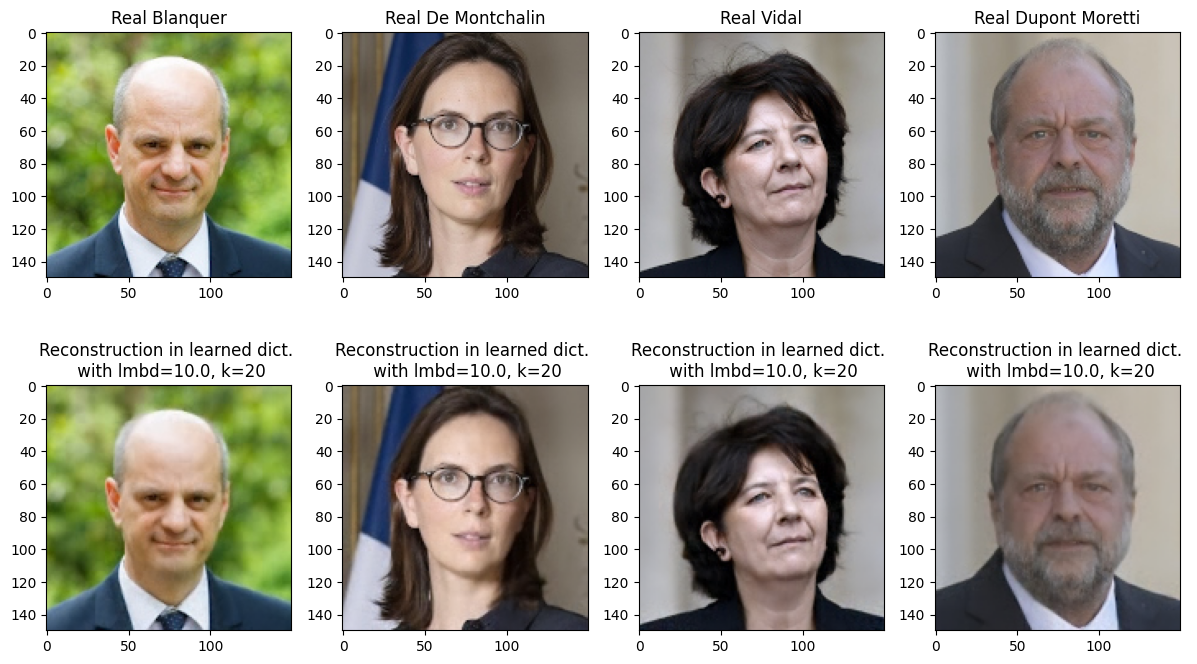

In [8]:
# Reconstructed patches
d, n = X_learn.shape
P_est = D_learn @ X_learn  # P2 to P5 estimates concatenated
P2_est = P_est[:, int(0 * n / 4) : int(1 * n / 4)]  # P2 estimate de-concatenated
P3_est = P_est[:, int(1 * n / 4) : int(2 * n / 4)]  # P3 estimate de-concatenated
P4_est = P_est[:, int(2 * n / 4) : int(3 * n / 4)]  # P4 estimate de-concatenated
P5_est = P_est[:, int(3 * n / 4) : int(4 * n / 4)]  # P5 estimate de-concatenated

# Images extracted from reconstructed patches
Im2_est = patch2image(P2_est, dims, skip, Im2.shape)
Im3_est = patch2image(P3_est, dims, skip, Im3.shape)
Im4_est = patch2image(P4_est, dims, skip, Im4.shape)
Im5_est = patch2image(P5_est, dims, skip, Im5.shape)

plt.figure(figsize=(12, 7))
plt.subplot(241)
plt.title("Real Blanquer")
plt.imshow(Im2)
plt.subplot(242)
plt.title("Real De Montchalin")
plt.imshow(Im3)
plt.subplot(243)
plt.title("Real Vidal")
plt.imshow(Im4)
plt.subplot(244)
plt.title("Real Dupont Moretti")
plt.imshow(Im5)
plt.subplot(245)
plt.title("Reconstruction in learned dict. \n with lmbd={}, k={}".format(lmbd, k))
plt.imshow(Im2_est)
plt.subplot(246)
plt.title("Reconstruction in learned dict. \n with lmbd={}, k={}".format(lmbd, k))
plt.imshow(Im3_est)
plt.subplot(247)
plt.title("Reconstruction in learned dict. \n with lmbd={}, k={}".format(lmbd, k))
plt.imshow(Im4_est)
plt.subplot(248)
plt.title("Reconstruction in learned dict. \n with lmbd={}, k={}".format(lmbd, k))
plt.imshow(Im5_est)
plt.tight_layout()
plt.show()

#### Using ISTA to fill corrupted pixels with the dictionary learned

In [9]:
# Problem hyperparameters
lmbd    = 1e2       # regularization strength
k       = 20        # target sparsity in the problem solution
tol     = 1e-3      # tolerance stopping criterion
maxit   = 20        # iteration stopping criterion

# Solve the problem
#   - Input the patches of the corrupted image
#   - Input the learned dictionary instead of the DCT one
#   - Tell the function where missing pixels are with mask=P0
_, X, e = ista(P1_tag, D_learn, lmbd, M=P0, k=k, tol=tol, maxit=maxit)

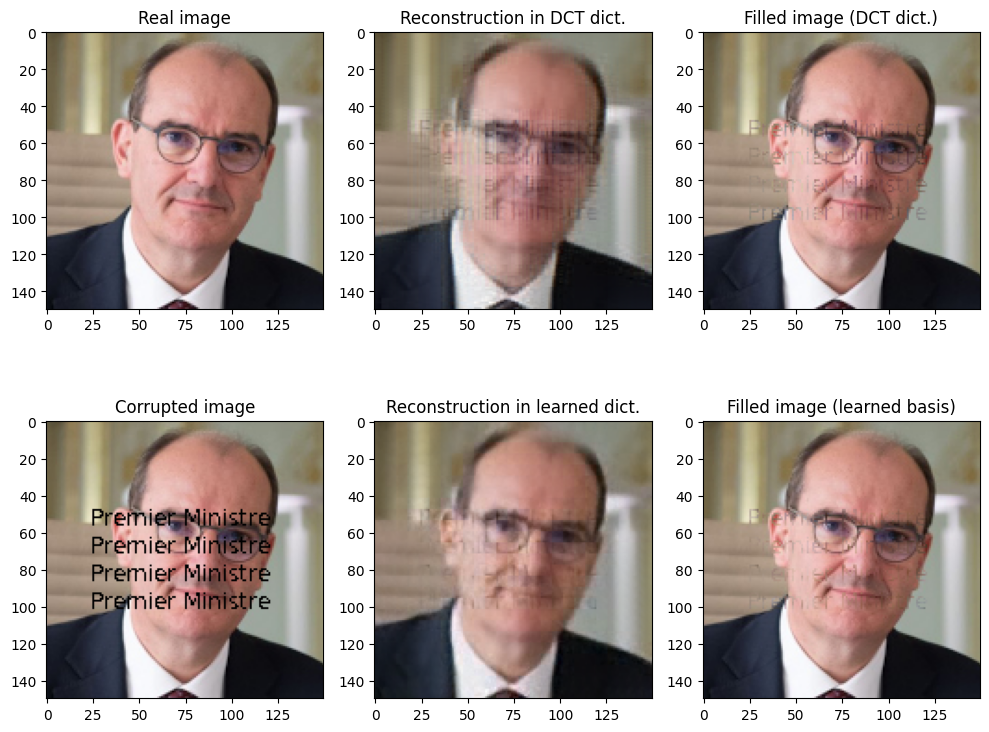

In [10]:
# Reconstructed image from patches
P1_hat_learn = D_learn @ X
Im1_hat_learn = patch2image(P1_hat_learn, dims, skip, Im1.shape)

# Image where corrupted pixels are filled with the reconstructed image
corrupted = np.invert(P0)
P1_fill_learn = np.copy(P1_tag)
P1_fill_learn[corrupted] = P1_hat_learn[corrupted]
Im1_fill_learn = patch2image(P1_fill_learn, dims, skip, Im1.shape)

# Displays
plt.figure(figsize=(10, 8))
plt.subplot(231)
plt.title("Real image")
plt.imshow(Im1)
plt.subplot(232)
plt.title("Reconstruction in DCT dict.")
plt.imshow(Im1_hat)
plt.subplot(233)
plt.title("Filled image (DCT dict.)")
plt.imshow(Im1_fill)
plt.subplot(234)
plt.title("Corrupted image")
plt.imshow(Im1_tag)
plt.subplot(235)
plt.title("Reconstruction in learned dict.")
plt.imshow(Im1_hat_learn)
plt.subplot(236)
plt.title("Filled image (learned basis)")
plt.imshow(Im1_fill_learn)
plt.tight_layout()
plt.show()